# Evaluation Board

In [2]:
%matplotlib inline
import os, sys
import glob, json
import shutil

import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path += [os.path.abspath('.'), os.path.abspath('..')]  # Add path to root
from birl.utilities.data_io import update_path
from birl.utilities.evaluate import compute_ranking
from birl.utilities.visualisation import RadarChart
from bm_ANHIR.generate_regist_pairs import VAL_STATUS_TRAIN, VAL_STATUS_TEST

This notebook serves for computing extended statistics (e.g. metrics inliding ranks) and visualie some more statistics.

In [3]:
PATH_SUBMISSIONS = os.path.join(update_path('bm_ANHIR'), 'submissions')
PATH_TEMP = os.path.abspath(os.path.expanduser('~/Desktop/ANHIR_submissions'))
PATH_DATASET = os.path.join(update_path('bm_ANHIR'), 'dataset_ANHIR')
PATH_TABLE = os.path.join(PATH_DATASET, 'dataset_medium.csv')
PATH_LNDS_PROVIDED = os.path.join(PATH_DATASET, 'landmarks_all')
PATH_LNDS_COMPLATE = os.path.join(PATH_DATASET, 'landmarks_all')
PATH_COMP_BM = os.path.join(PATH_DATASET, 'computer-performances_cmpgrid-71.json')

## Parse and load submissions

All submissions are expected to be as a zip archives in single folder. The archive name is the author name.

In [4]:
# Find all archives and unzip them to the same folder.
archive_paths = sorted(glob.glob(os.path.join(PATH_SUBMISSIONS, '*.zip')))
submission_dirs = []

for path_zip in tqdm.tqdm(archive_paths, desc='unzipping'):
    sub = os.path.join(PATH_TEMP, os.path.splitext(os.path.basename(path_zip))[0])
    os.system('unzip %s -d %s' % (path_zip, sub))
    sub_ins = glob.glob(os.path.join(sub, '*'))
    if len(sub_ins) == 1:  # if the zip subfolder contain only one folder move it up
        [shutil.move(p, sub) for p in glob.glob(os.path.join(sub_ins[0], '*'))]
    submission_dirs.append(sub)

unzipping: 100%|██████████| 12/12 [00:01<00:00,  6.02it/s]


Parse submissions and compute the final metrics. This can be computed just once.

In [ ]:
import bm_ANHIR.evaluate_submission

for path_sub in tqdm.tqdm(submission_dirs, desc='evaluation'):
    path_json = bm_ANHIR.evaluate_submission.main(
        path_experiment=path_sub,
        path_cover=PATH_TABLE,
        path_dataset=PATH_LNDS_PROVIDED,
        path_reference=PATH_LNDS_COMPLATE,
        path_comp_bm=PATH_COMP_BM,
        path_output=path_sub,
        min_landmarks=1., details=True)
    shutil.copy(os.path.join(path_sub, 'metrics.json'),
                os.path.join(PATH_SUBMISSIONS, os.path.basename(path_sub) + '.json'))

Load parsed measures from each submission/experiment.

In [6]:
submission_paths = sorted(glob.glob(os.path.join(PATH_SUBMISSIONS, '*.json')))
submissions = {}
for path_sub in tqdm.tqdm(submission_paths, desc='loading'):
    with open(path_sub, 'r') as fp:
        metrics = json.load(fp)
    submissions[os.path.splitext(os.path.basename(path_sub))[0]] = metrics

print ('Users: %r' % submissions.keys())

loading: 100%|██████████| 12/12 [00:00<00:00, 89.09it/s]

Users: dict_keys(['BmUnwarpJ', 'HistoReg', 'Mohammed', 'RNiftyReg-linear', 'delamoer', 'lMW', 'masi', 'nick.weiss', 'pszma2', 'punithakumar', 'zhaoshuaibit', 'zsyzzsoft'])


In [7]:
# split the particular fields inside the measured items
users = list(submissions.keys())
print ('Fields: %r' % submissions[users[0]].keys())
user_aggreg = {u: submissions[u]['aggregates'] for u in users}
user_computer = {u: submissions[u]['computer'] for u in users}
user_cases = {u: submissions[u]['cases'] for u in users}
print ('required-landmarks: %r' % [submissions[u]['required-landmarks'] for u in users])

Fields: dict_keys(['aggregates', 'cases', 'computer', 'submission-time', 'required-landmarks'])
required-landmarks: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## Compute ranked measures

Extend the aggregated statistic by Rank measures such as compute ranking over all cases for each selected field and average it

In [8]:
for robust in [True, False]:  # iterate over Robust or all cases
    for field, field_agg in [('rTRE-Median', 'Average-Rank-Median-rTRE'),
                             ('rTRE-Max', 'Average-Rank-Max-rTRE')]:
        user_cases = compute_ranking(user_cases, field)
        field_agg = field_agg + '-Robust' if robust else field_agg
        for user in users:
            # chose inly robyst if it is required
            vals = [user_cases[user][cs][field + '_rank'] for cs in user_cases[user]
                    if (robust and user_cases[user][cs]['Robustness']) or (not robust)]
            user_aggreg[user][field_agg] = np.mean(vals)

Show the raw table with global statiscit (joint training and testing/evalaution).

In [9]:
cols_general = [col for col in pd.DataFrame(user_aggreg).T.columns 
                if not any(n in col for n in [VAL_STATUS_TRAIN, VAL_STATUS_TEST])]
pd.DataFrame(user_aggreg).T.sort_values('Average-Rank-Median-rTRE')[cols_general]

,Average-Average-rTRE,Average-Average-rTRE-Robust,Average-Max-rTRE,Average-Max-rTRE-Robust,Average-Median-rTRE,Average-Median-rTRE-Robust,Average-Norm-Time,Average-Norm-Time-Robust,Average-Rank-Max-rTRE,Average-Rank-Max-rTRE-Robust,...,Average-Robustness,Average-used-landmarks,Median-Average-rTRE,Median-Average-rTRE-Robust,Median-Max-rTRE,Median-Max-rTRE-Robust,Median-Median-rTRE,Median-Median-rTRE-Robust,Median-Norm-Time,Median-Norm-Time-Robust
zsyzzsoft,0.004728,0.003536,0.014896,0.013299,0.004096,0.002887,0.000705,0.000706,2.440748,2.420833,...,0.997921,1.025250,0.001203,0.001169,0.004617,0.004464,0.001021,0.001016,0.000510,0.000510
nick.weiss,0.005188,0.004317,0.025986,0.024339,0.003853,0.002923,0.145392,0.145501,4.750520,4.735417,...,0.997921,1.025250,0.002866,0.002856,0.018443,0.018308,0.001815,0.001811,0.141754,0.141826
HistoReg,0.004070,0.004070,0.023043,0.023043,0.002793,0.002793,1.451193,1.451193,4.143451,4.143451,...,1.000000,1.025198,0.003010,0.003010,0.017465,0.017465,0.001918,0.001918,1.374846,1.374846
lMW,0.005638,0.005612,0.029979,0.029906,0.003806,0.003779,6.863679,6.860032,5.935551,5.922917,...,0.997921,1.025250,0.003395,0.003381,0.023037,0.022995,0.001973,0.001968,5.791019,5.787261
zhaoshuaibit,0.004669,0.004661,0.022593,0.022578,0.003480,0.003475,6.098517,6.106647,4.939709,4.929167,...,0.997921,1.026104,0.003490,0.003487,0.017278,0.017215,0.002565,0.002553,4.824366,4.825087
delamoer,0.006047,0.005838,0.026116,0.025769,0.004612,0.004391,7.127142,7.155800,5.596674,5.556485,...,0.993763,1.025356,0.004652,0.004627,0.020775,0.020765,0.003314,0.003312,7.488842,7.508170
masi,0.010362,0.007182,0.038618,0.033263,0.008724,0.005648,9.628429,9.131541,6.135135,5.628440,...,0.937634,1.027798,0.003761,0.003355,0.023273,0.020580,0.002501,0.002223,NaN,8.767961
BmUnwarpJ,0.068075,0.050743,0.135359,0.107761,0.066945,0.049563,6.598389,6.608330,7.713098,7.478747,...,0.929314,1.002125,0.009031,0.007749,0.043462,0.038716,0.005499,0.004741,6.038773,6.030344
Mohammed,0.025057,0.018315,0.074994,0.062795,0.021154,0.014854,2.540539,2.549469,8.594595,8.571429,...,0.959315,1.029598,0.010619,0.010014,0.044209,0.042897,0.008023,0.007522,NaN,2.352564
punithakumar,0.056947,0.017091,0.119045,0.047116,0.054942,0.015484,1.470925,1.458838,8.486486,7.914005,...,0.846154,1.034914,0.010979,0.009050,0.035972,0.031842,0.009043,0.007355,1.367489,1.370462


Show separatlyraw table with statistic for tran and tes cases separatly.

In [10]:
from IPython.display import display
for state in [VAL_STATUS_TRAIN, VAL_STATUS_TEST]:
    cols = [col for col in pd.DataFrame(user_aggreg).T.columns if state in col]
    display(pd.DataFrame(user_aggreg).T.sort_values('Average-Rank-Median-rTRE')[cols])

,Average-Average-rTRE_training,Average-Max-rTRE_training,Average-Median-rTRE_training,Average-Robustness_training,Median-Average-rTRE_training,Median-Max-rTRE_training,Median-Median-rTRE_training
zsyzzsoft,0.000132,0.000630,0.000111,1.000000,0.000124,0.000450,0.000106
nick.weiss,0.006096,0.027120,0.004924,0.995652,0.002964,0.018286,0.001857
HistoReg,0.003902,0.022146,0.002717,1.000000,0.003058,0.016792,0.001948
lMW,0.006021,0.031823,0.004042,1.000000,0.003656,0.023500,0.002023
zhaoshuaibit,0.003811,0.020166,0.002733,1.000000,0.003421,0.016496,0.002447
delamoer,0.007955,0.028522,0.006701,0.986957,0.006027,0.022732,0.005048
masi,0.014693,0.049695,0.013028,0.869159,0.005126,0.027064,0.003106
BmUnwarpJ,0.036243,0.085343,0.034088,0.939130,0.010063,0.045554,0.005869
Mohammed,0.020402,0.068639,0.016701,0.968468,0.011298,0.045754,0.008213
punithakumar,0.060474,0.126252,0.059492,0.847826,0.011664,0.037880,0.009985


,Average-Average-rTRE_evaluation,Average-Max-rTRE_evaluation,Average-Median-rTRE_evaluation,Average-Robustness_evaluation,Median-Average-rTRE_evaluation,Median-Max-rTRE_evaluation,Median-Median-rTRE_evaluation
zsyzzsoft,0.008939,0.027968,0.007748,0.996016,0.002884,0.017598,0.002058
nick.weiss,0.004355,0.024946,0.002871,1.000000,0.002706,0.018710,0.001790
HistoReg,0.004224,0.023865,0.002862,1.000000,0.002910,0.019016,0.001903
lMW,0.005287,0.028290,0.003590,0.996016,0.003220,0.022229,0.001913
zhaoshuaibit,0.005456,0.024817,0.004164,0.996016,0.003724,0.019671,0.002646
delamoer,0.004299,0.023912,0.002697,1.000000,0.003234,0.018857,0.002267
masi,0.006393,0.028467,0.004780,0.996016,0.003116,0.019585,0.002056
BmUnwarpJ,0.097243,0.181189,0.097053,0.920319,0.008032,0.038716,0.005398
Mohammed,0.029323,0.080817,0.025233,0.951020,0.010200,0.041996,0.007908
punithakumar,0.053715,0.112441,0.050774,0.844622,0.010020,0.035309,0.008247


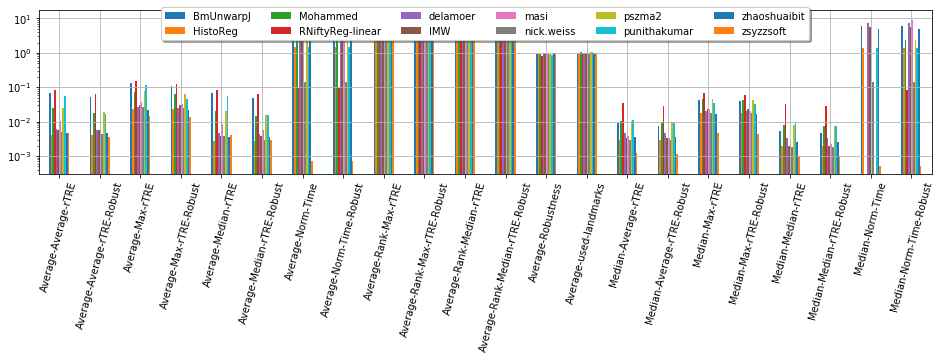

In [11]:
ax = pd.DataFrame(user_aggreg).T[cols_general].T.plot.bar(figsize=(16, 3), grid=True, logy=True, rot=75)
_= ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=int(len(users) / 2), fancybox=True, shadow=True)

## Compare statistic "train" vs "test"

Compute sts. on training and testing case also foor newly add rank measures.

In [12]:
for state in [VAL_STATUS_TRAIN, VAL_STATUS_TEST]:
    for field, field_agg in [# ('rTRE-Median', 'Average-Median-rTRE'),
                             ('rTRE-Median_rank', 'Average-Rank-Median-rTRE'),
                             # ('rTRE-Max', 'Average-Max-rTRE'),
                             ('rTRE-Max_rank', 'Average-Rank-Max-rTRE')]:
        for user in users:
            # chose inly robyst if it is required
            vals = [user_cases[user][cs][field] for cs in user_cases[user]
                    if user_cases[user][cs]['Status'] == state]
            user_aggreg[user][field_agg + '_' + state] = np.nanmean(vals)

Display just raw table with results.

In [13]:
df = pd.DataFrame(user_aggreg).T
cols = [col for col in df.columns if any(st in col for st in [VAL_STATUS_TRAIN, VAL_STATUS_TEST])]
df[cols].sort_values('Average-Rank-Median-rTRE_evaluation')

,Average-Average-rTRE_evaluation,Average-Average-rTRE_training,Average-Max-rTRE_evaluation,Average-Max-rTRE_training,Average-Median-rTRE_evaluation,Average-Median-rTRE_training,Average-Rank-Max-rTRE_evaluation,Average-Rank-Max-rTRE_training,Average-Rank-Median-rTRE_evaluation,Average-Rank-Median-rTRE_training,Average-Robustness_evaluation,Average-Robustness_training,Median-Average-rTRE_evaluation,Median-Average-rTRE_training,Median-Max-rTRE_evaluation,Median-Max-rTRE_training,Median-Median-rTRE_evaluation,Median-Median-rTRE_training
nick.weiss,0.004355,0.006096,0.024946,0.027120,0.002871,0.004924,4.852590,4.639130,2.856574,3.265217,1.000000,0.995652,0.002706,0.002964,0.018710,0.018286,0.001790,0.001857
HistoReg,0.004224,0.003902,0.023865,0.022146,0.002862,0.002717,4.127490,4.160870,3.382470,3.513043,1.000000,1.000000,0.002910,0.003058,0.019016,0.016792,0.001903,0.001948
lMW,0.005287,0.006021,0.028290,0.031823,0.003590,0.004042,5.637450,6.260870,3.450199,3.917391,0.996016,1.000000,0.003220,0.003656,0.022229,0.023500,0.001913,0.002023
delamoer,0.004299,0.007955,0.023912,0.028522,0.002697,0.006701,5.007968,6.239130,4.179283,7.908696,1.000000,0.986957,0.003234,0.006027,0.018857,0.022732,0.002267,0.005048
zsyzzsoft,0.008939,0.000132,0.027968,0.000630,0.007748,0.000111,3.749004,1.013043,4.434263,1.000000,0.996016,1.000000,0.002884,0.000124,0.017598,0.000450,0.002058,0.000106
masi,0.006393,0.014693,0.028467,0.049695,0.004780,0.013028,5.501992,6.826087,5.282869,6.917391,0.996016,0.869159,0.003116,0.005126,0.019585,0.027064,0.002056,0.003106
zhaoshuaibit,0.005456,0.003811,0.024817,0.020166,0.004164,0.002733,5.211155,4.643478,6.358566,4.752174,0.996016,1.000000,0.003724,0.003421,0.019671,0.016496,0.002646,0.002447
BmUnwarpJ,0.097243,0.036243,0.181189,0.085343,0.097053,0.034088,7.474104,7.973913,8.075697,7.878261,0.920319,0.939130,0.008032,0.010063,0.038716,0.045554,0.005398,0.005869
Mohammed,0.029323,0.020402,0.080817,0.068639,0.025233,0.016701,8.625498,8.560870,9.318725,8.947826,0.951020,0.968468,0.010200,0.011298,0.041996,0.045754,0.007908,0.008213
punithakumar,0.053715,0.060474,0.112441,0.126252,0.050774,0.059492,8.474104,8.500000,9.729084,9.647826,0.844622,0.847826,0.010020,0.011664,0.035309,0.037880,0.008247,0.009985


Transform the case format data to be simple form with extra colums for used and case ID to be able to draw a violine plot later.

In [14]:
dfs_cases = []
for usr in users:
    df = pd.DataFrame(user_cases[usr]).T
    df['user'] = usr
    df['case'] = df.index
    dfs_cases.append(df)
df_cases = pd.concat(dfs_cases).reset_index()

for col in df_cases.columns:
    try: df_cases[col] = pd.to_numeric(df_cases[col])
    except Exception: pass
# df_cases.head()

Showing several violine plots depending on what is the target variable.

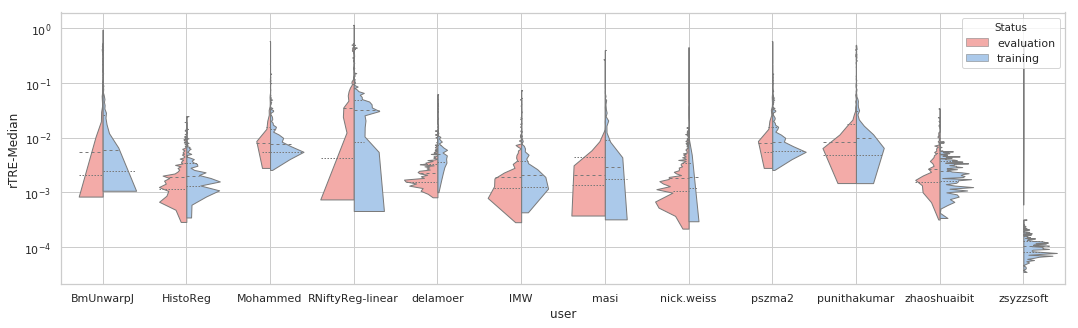

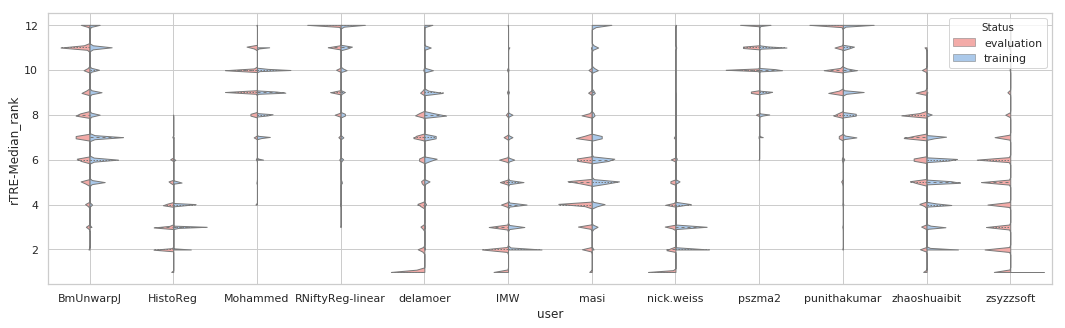

In [15]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
for field, log in [('rTRE-Median', True), ('rTRE-Median_rank', False)]:
    fig, ax = plt.subplots(figsize=(18, 5))
    sns.violinplot(ax=ax, data=df_cases, x='user', hue='Status', y=field,
                   cut=0, split=True, bw=0.02, scale='area', scale_hue=True, inner='quartile',
                   palette={"evaluation": "r", "training": "b"}, linewidth=1., rot=60)
    if log:
        ax.set_yscale('log')
    ax.grid(True)

## Visualise global results

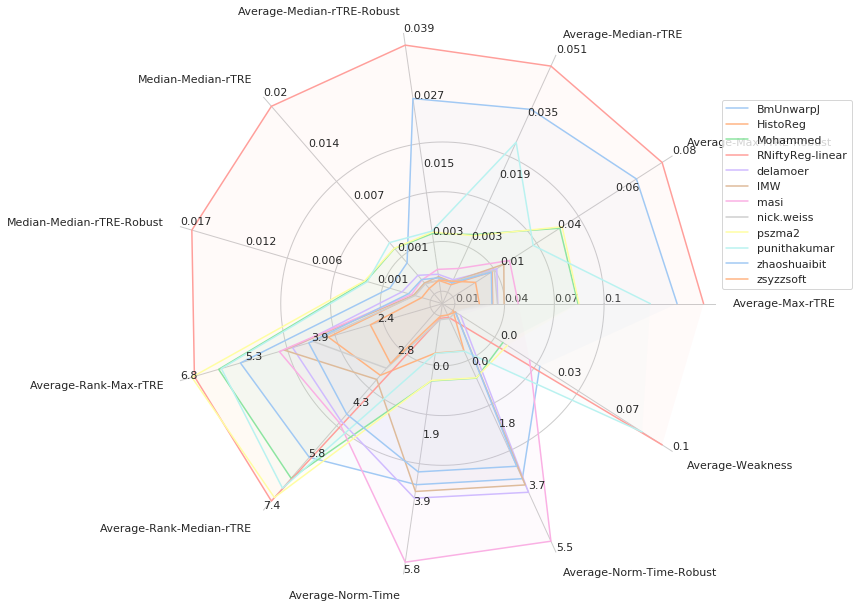

In [16]:
fields = ['Average-Max-rTRE', 'Average-Max-rTRE-Robust',
          'Average-Median-rTRE', 'Average-Median-rTRE-Robust',
          'Median-Median-rTRE', 'Median-Median-rTRE-Robust',
          'Average-Rank-Max-rTRE', 'Average-Rank-Median-rTRE',
          'Average-Norm-Time', 'Average-Norm-Time-Robust',
          'Average-Robustness',]
df = pd.DataFrame(user_aggreg).T[fields]
df['Average-Weakness'] = 1 - df['Average-Robustness']
del df['Average-Robustness']

radar = RadarChart(df, fig=plt.figure(figsize=(12, 8)))

## Visualise partial results

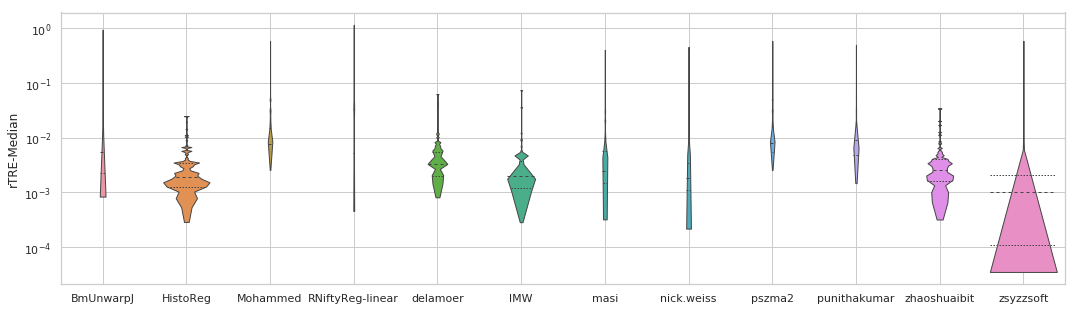

In [17]:
# from plotly.offline import init_notebook_mode, plot, iplot
# import plotly.figure_factory as ff
# init_notebook_mode(connected=True)

for field in ['rTRE-Median']:  # , 'rTRE-Max'
    df = pd.DataFrame({us: {cs: user_cases[us][cs][field] for cs in user_cases[us]} for us in users})
    # fig = ff.create_distplot([df[us].values for us in users], users, bin_size=0.001)
    # iplot(fig, logx=True)
    fig, ax = plt.subplots(figsize=(18, 5))
    sns.violinplot(ax=ax, data=df, split=True, cut=0, bw=.005, scale='area', inner='quartile', linewidth=1.)
    _ = ax.set_yscale('log'), ax.set_ylabel(field)
    ax.grid(True)
